In [1]:
import pandas as pd
from scipy.spatial import distance
import os
# time
import pytz
import datetime
# plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as po
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
# maths and statistics
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from scipy.stats import kstest,ks_2samp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
# process mining
import pm4py
from pm4py.objects.log.importer import xes
from pm4py.objects.conversion.log.versions import to_dataframe
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.conversion.log import factory as conversion_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory
# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
wd = os.getcwd()
"""
get all filenames in working directory
then collect log containing folders
get log files paths and collect logs

"""
logs_paths = []
for file in os.listdir(wd):
    if file.endswith(".xes_"):
        for f in os.listdir(file):
            if f.endswith(".xes"):
                logs_paths.append(os.path.join(wd+'\\'+file, f))
print(logs_paths)

['C:\\PM contest\\Common challenge\\DomesticDeclarations.xes_\\DomesticDeclarations.xes', 'C:\\PM contest\\Common challenge\\InternationalDeclarations.xes_\\InternationalDeclarations.xes', 'C:\\PM contest\\Common challenge\\PermitLog.xes_\\PermitLog.xes', 'C:\\PM contest\\Common challenge\\PrepaidTravelCost.xes_\\PrepaidTravelCost.xes', 'C:\\PM contest\\Common challenge\\RequestForPayment.xes_\\RequestForPayment.xes']


### Таблицы

In [3]:
domestic_declarations = xes_importer.apply(wd + '\DomesticDeclarations.xes_\DomesticDeclarations.xes')

In [4]:
int_declarations = xes_importer.apply(wd + '\InternationalDeclarations.xes_\InternationalDeclarations.xes')

In [5]:
permit_log = xes_importer.apply(wd + '\PermitLog.xes_\PermitLog.xes')

In [6]:
prepaid_travel_cost = xes_importer.apply(wd + '\PrepaidTravelCost.xes_\PrepaidTravelCost.xes')

In [7]:
request_for_payment = xes_importer.apply(wd + '\RequestForPayment.xes_\RequestForPayment.xes')

In [8]:
permit_log = pd.read_csv('C://PM contest//Common challenge//PermitLog.xes_//compact_PermitLog.csv')
permit_log['time:timestamp']=permit_log['time:timestamp'].map(lambda x: datetime.datetime.fromisoformat(x))

In [9]:
domestic_declarations = to_dataframe.apply(domestic_declarations)
int_declarations = to_dataframe.apply(int_declarations)
permit_log = to_dataframe.apply(permit_log)
prepaid_travel_cost = to_dataframe.apply(prepaid_travel_cost)
request_for_payment = to_dataframe.apply(request_for_payment)

In [10]:
dfs_list = [domestic_declarations,int_declarations,permit_log,prepaid_travel_cost,request_for_payment]

### Timestamp with timezone --> timestamp unified

In [11]:
"""
converts to UTC-format for unified timestamp format
:param: df - selected table
:param: time_column - column with the following time format %Y-%m-%d HH:MM:SS+0X:00
:return: converted to UTC-format timestmp without timezone
"""

def to_utc(df, time_column):
    utc = pytz.timezone('UTC')
    df[time_column] = df[time_column].map(lambda x: x.astimezone(utc).replace(tzinfo=None))
    return df

In [12]:
for df in dfs_list:
    df = to_utc(df, 'time:timestamp')

### 3. Is there are difference in throughput between national and international trips?

In [13]:
def time_period_selection(df, start_date, end_date, time_column):
    df = df[(df[time_column]>=start_date)&(df[time_column]<=end_date)]
    return df

In [14]:
td_17 = time_period_selection(domestic_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
td_18 = time_period_selection(domestic_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

ti_17 = time_period_selection(int_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
ti_18 = time_period_selection(int_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

rp_17 = time_period_selection(request_for_payment,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
rp_18 = time_period_selection(request_for_payment,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

In [15]:
dd_17 = domestic_declarations[domestic_declarations['case:id'].isin(set(td_17['case:id']))].reset_index(drop=True)
dd_18 = domestic_declarations[domestic_declarations['case:id'].isin(set(td_18['case:id']))].reset_index(drop=True)

id_17 = int_declarations[int_declarations['case:id'].isin(set(ti_17['case:id']))].reset_index(drop=True)
id_18 = int_declarations[int_declarations['case:id'].isin(set(ti_18['case:id']))].reset_index(drop=True)

rp_17 = request_for_payment[request_for_payment['case:Rfp_id'].isin(set(rp_17['case:Rfp_id']))].reset_index(drop=True)
rp_18 = request_for_payment[request_for_payment['case:Rfp_id'].isin(set(rp_18['case:Rfp_id']))].reset_index(drop=True)

In [16]:
dd_18 = dd_18[~dd_18['case:id'].isin(set(dd_17['case:id']))]
id_18 = id_18[~id_18['case:id'].isin(set(id_17['case:id']))]

rpf_18 = rp_18[~rp_18['case:Rfp_id'].isin(set(rp_17['case:Rfp_id']))]

In [17]:
len(set(dd_17['case:id'])), len(set(dd_18['case:id']))

(2240, 8260)

In [18]:
len(set(id_17['case:id'])), len(set(id_18['case:id']))

(1552, 4897)

### Кластеризация процессов 

> Label encoder'ом перевела в цифры все состояния, которые есть в столбце case:concept, полученные значения перевела в стобцы вида col_(порядковый номер признака) и дальше по каждой декларации проставляла 0 - если нет этого этапа, 1 - если есть. Потом я взяла эти признаки как отдельные пространства и спроецировала на плоскость. Можешь попробовать РСА, но я попробовала - никаких инсайтов. Отлично работает TSNE. Дальше, когда мы спроецировали на плоскость, можем проводить кластерный анализ: DBSCAN, KMeans, Hierarchical Clustering, Spectral и прочие.
https://scikit-learn.org/stable/modules/clustering.html
Я бы пофайнтюнила DBSCAN, KMeans

In [61]:
def features_collection(d_frame, concept_name_column, case_id_column):
    le = preprocessing.LabelEncoder()
    le.fit(list(set(d_frame[concept_name_column])))
    outlier_label = len(list(set(d_frame[concept_name_column])))+2
    d_frame['concept:name:label']=le.transform(d_frame[concept_name_column].to_list())
    vectors_dd = pd.DataFrame(d_frame.groupby([case_id_column])['concept:name:label'].apply(lambda x: set(x)))
    vectors_dd['length'] = vectors_dd['concept:name:label'].map(lambda x: len(x))
    max_ = vectors_dd['length'].max()
    labels_set = set(d_frame['concept:name:label'])
    new_vecs = []
    for i in range(len(vectors_dd)):
        small_ = []
        for j in labels_set:
            if j in vectors_dd['concept:name:label'].iloc[i]:
                small_.append(1)
            else:
                small_.append(0)
        new_vecs.append(small_)
    vectors_dd['new_vecs'] = new_vecs
    column_names = []
    for i in range(len(labels_set)):
        name = 'col_'+str(i)
        column_names.append(name)
    for i in column_names:
        num = int(i.split('_')[-1])
        vectors_dd[i] = None
        list_ = []
        for j in range(len(vectors_dd)):
            list_.append(vectors_dd['new_vecs'].iloc[j][num])
        vectors_dd[i]=list_
    # clustering
    vectors_dd = vectors_dd.reset_index()
    #X = vectors_dd[column_names].values
    #tsne = TSNE(random_state=17)
    #tsne_representation = tsne.fit_transform(X)
    return vectors_dd, column_names #,tsne_representation, , X

In [62]:
ouvectors_id_18, oucnames = features_collection(id_18, 'case:Permit OrganizationalEntity', 'case:id')

In [68]:
ouvectors_id_18.columns = ['case:id', 'concept:name:label', 'length', 'new_vecs',
                          'col_30','col_31','col_32','col_33','col_34','col_35','col_36','col_37','col_38',
                           'col_39','col_40','col_41','col_42','col_43','col_44',
                           'col_45','col_46','col_47','col_48','col_49',
                           'col_50','col_51','col_52','col_53','col_54','col_55','col_56']

In [65]:
new_colnames = []
for i in range(len(oucnames)):
    n = 'col_'+str(i+30)
    new_colnames.append(n)

In [45]:
#X_dd_18, tsne_representation_dd_18, vectors_dd_18 = tsne_projecting(dd_18, 'concept:name', 'case:id')
evectors_id_18, ecnames = features_collection(id_18, 'concept:name', 'case:id')
#X_rp_18, tsne_representation_rp_18, vectors_rp_18 = tsne_projecting(rpf_18, 'concept:name', 'case:Rfp_id')

In [70]:
tdf_id_18 = pd.merge(evectors_id_18, ouvectors_id_18, how = 'left', on = 'case:id')

In [73]:
X_id_18 = tdf_id_18[new_colnames+ecnames].values

In [75]:
tsne = TSNE(random_state=17)
tsne_representation_id_18 = tsne.fit_transform(X_id_18)

In [76]:
#tdf_dd_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_dd_18['tsne_1'] = tsne_representation_dd_18[:,0]
#tdf_dd_18['tsne_2'] = tsne_representation_dd_18[:,1]

tdf_id_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
tdf_id_18['tsne_1'] = tsne_representation_id_18[:,0]
tdf_id_18['tsne_2'] = tsne_representation_id_18[:,1]

#tdf_rp_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_rp_18['tsne_1'] = tsne_representation_rp_18[:,0]
#tdf_rp_18['tsne_2'] = tsne_representation_rp_18[:,1]

### K-means

In [77]:
from sklearn.cluster import KMeans

In [81]:
disortions = []
K = range(1,15)
for k in K:
    kmean_model = KMeans(n_clusters = k)
    kmean_model.fit(tdf_id_18[['tsne_1','tsne_2']].values)
    disortions.append(kmean_model.inertia_)

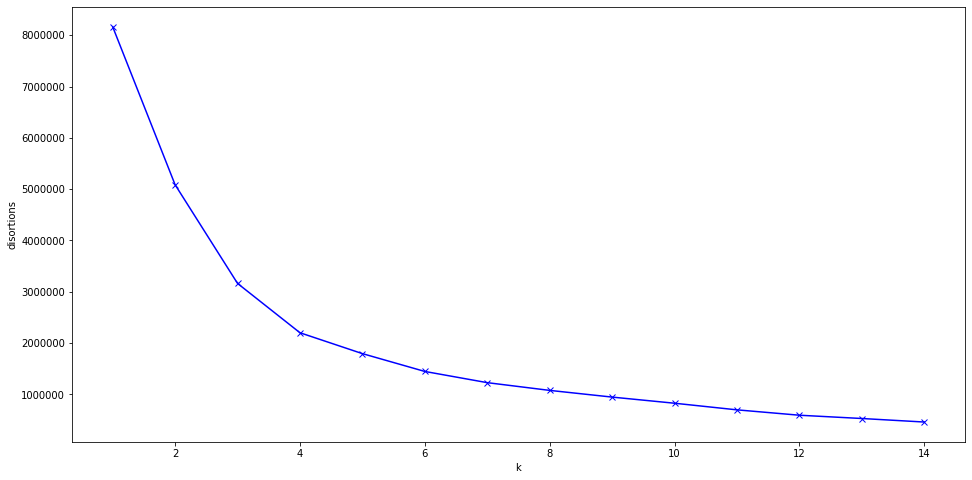

In [82]:
plt.figure(figsize=(16,8))
plt.plot(K, disortions, 'bx-')
plt.xlabel('k'),
plt.ylabel('disortions')
plt.show()

In [83]:
len(tdf_id_18[['tsne_1', 'tsne_2']])

4897

In [78]:
#kmean_model = KMeans(n_clusters = 4)
#kmean_model.fit(tdf_dd_18)
#tdf_dd_18['KMeans_label'] = kmean_model.labels_

kmean_model = KMeans(n_clusters = 4)
kmean_model.fit(tdf_id_18[['tsne_1', 'tsne_2']].values)
tdf_id_18['KMeans_label'] = kmean_model.labels_


In [79]:
kmean_model.cluster_centers_

array([[ -0.34182143,  50.217033  ],
       [ 20.747234  ,  -5.5719614 ],
       [-42.056835  ,  22.401133  ],
       [-20.23328   , -24.439175  ]], dtype=float32)

### Для поиска оптимального eps DBSCAN

In [84]:
def eps_search(n, X):
    neigh = NearestNeighbors(n_neighbors=n)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    return distances

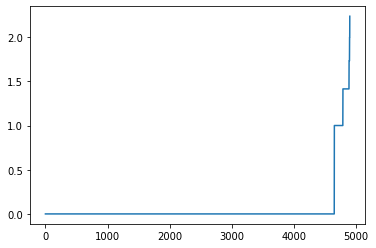

In [85]:
d = eps_search(2, X_id_18)

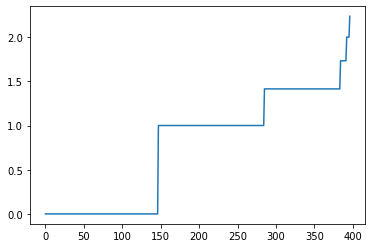

In [87]:
plt.plot(d[4500:])

### DBSCAN

> В DBSCAN мы в eps очерчиваем радиус окружности, а в min samples указваыем количество соседей в окружности, после чего мы такой кейс посчитаем кластером.


In [166]:
# Для домашних деклараций я фиксировала эти
#cluster = DBSCAN(eps = 0.5, min_samples = 80).fit(X_dd_18)
#tdf_dd_18['DBSCAN_label'] = cluster.labels_

# международные
cluster = DBSCAN(eps = 1.55, min_samples = 10).fit(X_id_18)
tdf_id_18['DBSCAN_label'] = cluster.labels_

In [168]:
fig = px.scatter(tdf_id_18, x = tsne_representation_id_18[:, 0], y = tsne_representation_id_18[:, 1],
                #color = tdf_id_18['DBSCAN_label'].to_list(),
                height = 800, width = 800,
                title = "DBSCAN domestic")
fig.update_layout(font_size =15)
#fig.show()

In [165]:
tdf_id_18['case:id'] = vectors_id_18['case:id']

In [152]:
id_18['case:Permit OrganizationalEntity'].value_counts()

organizational unit 65456    10700
organizational unit 65458     8602
organizational unit 65454     8301
organizational unit 65459     5639
organizational unit 65455     5431
organizational unit 65460     5169
organizational unit 65464     3630
organizational unit 65457     3432
organizational unit 65466     2879
organizational unit 65461      940
organizational unit 65469      608
organizational unit 65470      508
organizational unit 65472      260
organizational unit 65467      206
organizational unit 65475      188
organizational unit 65473      132
organizational unit 65480      132
organizational unit 65468      125
organizational unit 65482       85
organizational unit 65465       84
organizational unit 65471       83
organizational unit 65477       47
organizational unit 65484       33
organizational unit 65486       18
organizational unit 65462       13
organizational unit 65488       10
organizational unit 65478       10
Name: case:Permit OrganizationalEntity, dtype: int64

In [ ]:
tdf_id_18['DBSCAN_label'].value_counts()

In [143]:
selected_pl = permit_log[permit_log['case:travel permit number']=='travel permit number 424'].reset_index(drop = True)

In [147]:
third_cluster = int_declarations[int_declarations['case:concept:name'].isin(
    set(tdf_id_18[(tdf_id_18['DBSCAN_label']==1)]['case:id']))].reset_index(drop=True)

In [148]:
third_cluster.columns

Index(['id', 'org:resource', 'concept:name', 'time:timestamp', 'org:role',
       'case:Permit travel permit number', 'case:DeclarationNumber',
       'case:Amount', 'case:RequestedAmount', 'case:Permit TaskNumber',
       'case:Permit BudgetNumber', 'case:OriginalAmount',
       'case:Permit ProjectNumber', 'case:concept:name',
       'case:Permit OrganizationalEntity', 'case:travel permit number',
       'case:Permit RequestedBudget', 'case:id', 'case:Permit ID',
       'case:Permit id', 'case:BudgetNumber', 'case:Permit ActivityNumber',
       'case:AdjustedAmount'],
      dtype='object')

In [169]:
third_cluster.head()

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount
0,st_step 7198_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-01-06 10:13:23,EMPLOYEE,travel permit number 7193,declaration number 7195,662.163043,662.163043,task 427,...,declaration 7194,organizational unit 65455,travel permit number 7193,694.336959,declaration 7194,travel permit 7192,travel permit 7192,budget 145023,UNKNOWN,662.163043
1,st_step 7197_0,STAFF MEMBER,Permit APPROVED by ADMINISTRATION,2018-01-06 10:13:26,ADMINISTRATION,travel permit number 7193,declaration number 7195,662.163043,662.163043,task 427,...,declaration 7194,organizational unit 65455,travel permit number 7193,694.336959,declaration 7194,travel permit 7192,travel permit 7192,budget 145023,UNKNOWN,662.163043
2,st_step 7196_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2018-01-08 10:54:51,SUPERVISOR,travel permit number 7193,declaration number 7195,662.163043,662.163043,task 427,...,declaration 7194,organizational unit 65455,travel permit number 7193,694.336959,declaration 7194,travel permit 7192,travel permit 7192,budget 145023,UNKNOWN,662.163043
3,rv_travel permit 7192_6,STAFF MEMBER,Start trip,2018-01-15 23:00:00,EMPLOYEE,travel permit number 7193,declaration number 7195,662.163043,662.163043,task 427,...,declaration 7194,organizational unit 65455,travel permit number 7193,694.336959,declaration 7194,travel permit 7192,travel permit 7192,budget 145023,UNKNOWN,662.163043
4,rv_travel permit 7192_7,STAFF MEMBER,End trip,2018-01-18 23:00:00,EMPLOYEE,travel permit number 7193,declaration number 7195,662.163043,662.163043,task 427,...,declaration 7194,organizational unit 65455,travel permit number 7193,694.336959,declaration 7194,travel permit 7192,travel permit 7192,budget 145023,UNKNOWN,662.163043


In [129]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [130]:
# прямой граф
log = conversion_factory.apply(third_cluster)
dfg = dfg_factory.apply(log)
dfg = dfg_factory.apply(log)
gviz = dfg_vis_factory.apply(dfg, log=log)
#gviz.render("first")

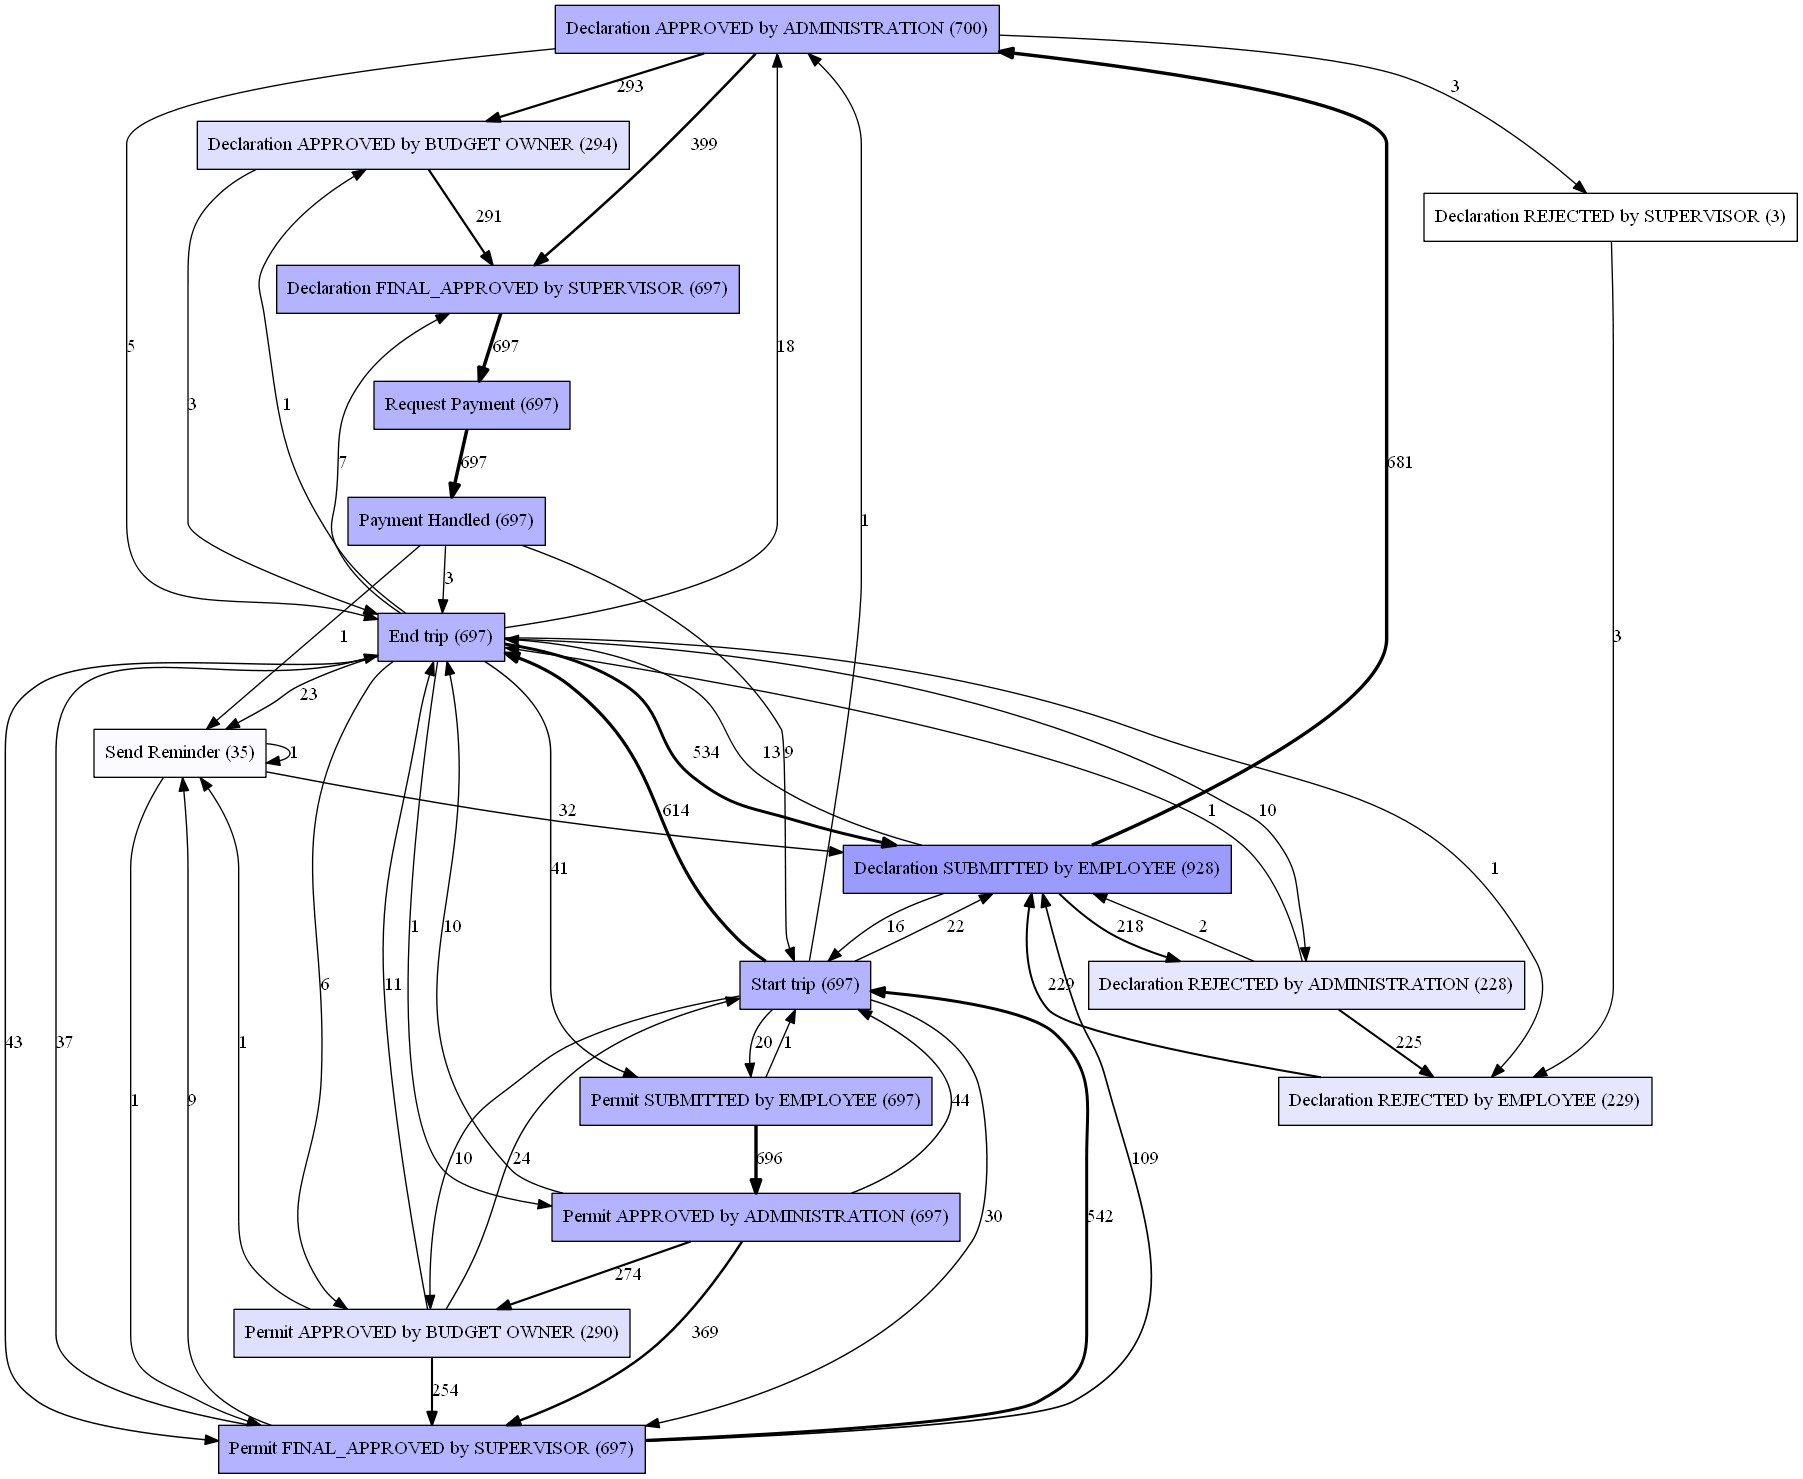

In [131]:
dfg_vis_factory.view(gviz)

In [132]:
from pm4py.algo.discovery.heuristics import factory as heuristics_miner

In [133]:
heu_net = heuristics_miner.apply_heu(log, parameters={"min_act_count":10})
                                                      #"dfg_pre_cleaning_noise_thresh":0.05})

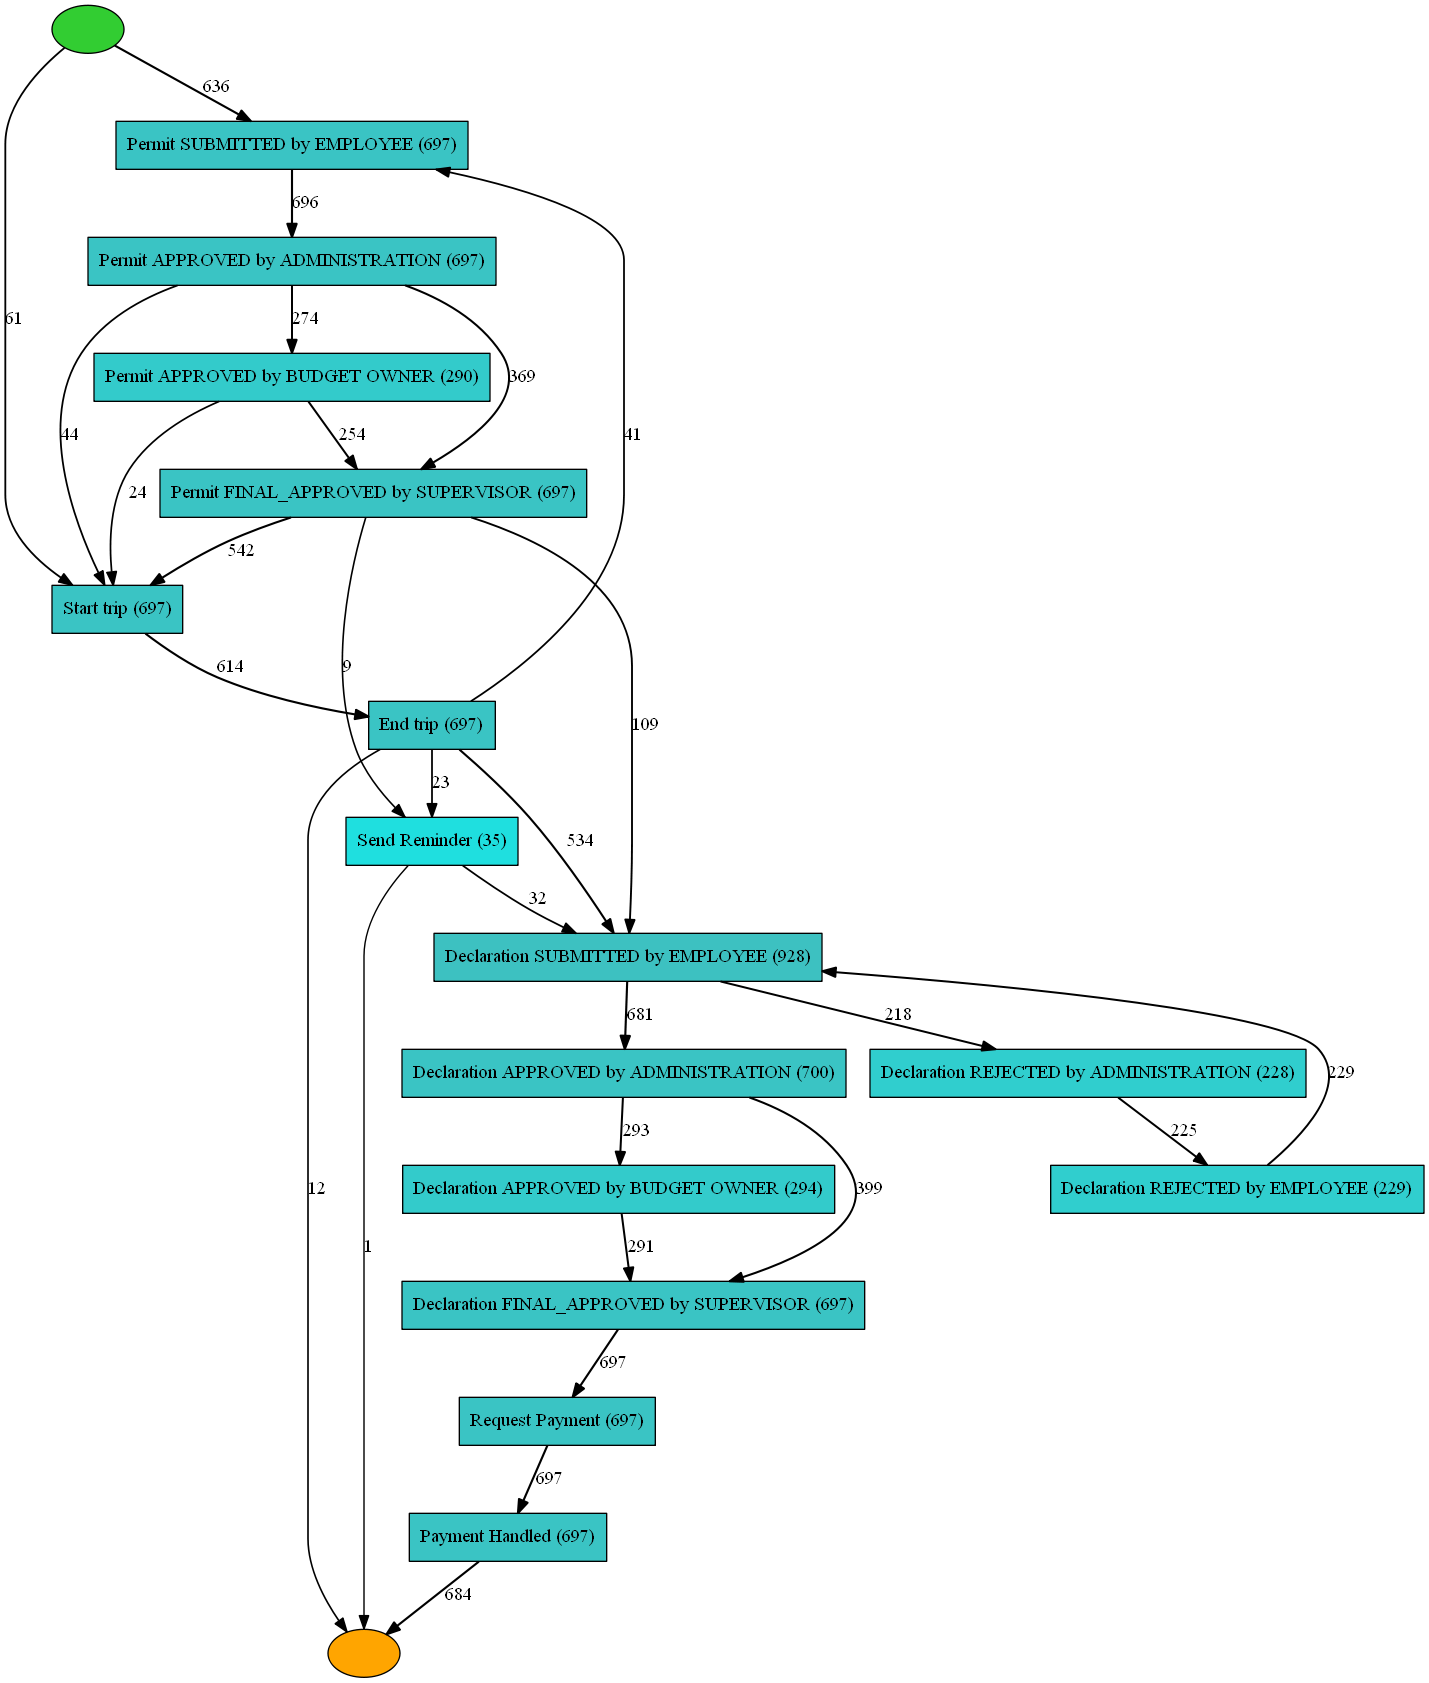

In [134]:
from pm4py.visualization.heuristics_net import factory as hn_vis_factory
gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)